# Mod 4 Project - Which 5 Zip Codes in the United States are the best real estate investments?

By: Gabe Blatsetein

Presentation: Please see attached for the accompanied presentation (https://drive.google.com/file/d/11miM9kh4czveibeV7flx255YTSpYt9aV/view?usp=sharing)

Blog Post: https://gabertooth.github.io/mod_4_project_time_series  

### Introduction/Background 

#### Assumptions

 - The real estate firm, National Archive LLC,  is a multi million dollar RIT that has had a great year finacially.
 - Due to their outstanding financial position, the company has around XX amount in cash.
 - National Archive would like to invest in the zipcodes that have the highest rate of return.
 - The following analysis has expected holding periods: 3, 5, and 10 years.
 - The Zillow dataset provided by National Archive was used for this analysis as requested.

#### How does one define the best zipcodes?

As the consultant for National Archive, two major factors were taken into account to define the best zip code.

    1. ROI: Return on Investment was the first feature derived from the data set. This is a basic investment metric that measures essentially the price of a investment at the start of some time period x, subtracted from the     current market value of the asset; all divided by the original price.  
   \begin{equation*}ROI=\frac{Current Value - CostofInvestment}{CostofInvestment}
   \end{equation*}
        
        
        
    2. Average Price: The average price of each zip code was taken over the 25 year time period provided. This      provides insight into the price of the homes in each zip code market. Considering National Archive has plenty of capital, we do not have to worry about any monetary constraints.


Using the above factors, I was able to deduce where the biggest real estate return would be for National Archive. I decided to diversify the portfolio which I will touch on later. With any financial investment the golden rule of diversification is key. A investor does not want all of his or her money tied into one type of investment (financial world) or in this case region (Real Estate).  

# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd 
from pandas import Series #Imported necessary pandas libraries
import matplotlib.pyplot as plt #Imported matplotlib for visualizations & Visualizations will show up inline 
%matplotlib inline
import numpy as np #Imported numpy for basic arithmatic
from statsmodels.tsa.stattools import adfuller #Imported AdFuller test for stationarity check purposes
from pandas.plotting import autocorrelation_plot #Visualization used for ARMA model purposes
from statsmodels.tsa.arima_model import ARMA #Code for ARMA model
import statsmodels.api as sm #Imported stats
from statsmodels.tsa.arima_model import ARIMA #ARIMA model
from sklearn.metrics import mean_squared_error #Mean Squared Error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

df= pd.read_csv('zillow_data.csv')

df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [2]:
df['AvgHomePrice']= df.mean(skipna=True, axis=1) #Creating a new column for average home price

In [3]:
df['ROI']= (df.iloc[:,-2]-df.iloc[:,7])/df.iloc[:,7] #Creating the ROI column

In [4]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,AvgHomePrice,ROI
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,736192.955224,2.083782
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,312500,314100,315000,316600,318100,319600,321100,321800,217815.447761,0.365295
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320200,320400,320800,321200,321200,323000,326900,329900,259808.876866,0.567966
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,963776.619403,1.623971
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120000,120300,120300,120300,120300,120500,121000,121500,101380.914179,0.571798


Now that the data is loaded, the next step will be to turn the data from wide format into long format. Using the pandas melt method, we will transform our data set and rid our data of uneccesary data.

The most important columns are;

    1. Region Name: Zipcode in US
    2. City: US City 
    3. Metro: Metro area of Zipcode
    4. AvgHomePrice: The average historical homeprice for each zipcode
    5. ROI: Return on Investment from April 1996 until April 2018

In [5]:
df_melted=pd.melt(df, id_vars=['RegionName', 'City', 'Metro','AvgHomePrice', 'ROI'], value_vars=df.iloc[:,7:-3], var_name='Date', value_name='Price')

In [6]:
top_10_ROI= df[['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'AvgHomePrice', 'ROI']].sort_values('ROI', ascending= False).head(10)

In [7]:
top_10_ROI #Created a dataframe for the top 10 ROI zipcode

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,AvgHomePrice,ROI
117,62022,11211,New York,NY,New York,Kings,118,5.887785e+05,11.189940
1155,62033,11222,New York,NY,New York,Kings,1156,6.331605e+05,10.535523
475,62027,11216,New York,NY,New York,Kings,476,5.660419e+05,9.942505
191,60639,7302,Jersey City,NJ,New York,Hudson,192,5.901673e+05,9.403061
106,62026,11215,New York,NY,New York,Kings,107,1.063203e+06,8.941958
13864,62320,11975,Wainscott,NY,New York,Suffolk,13865,1.556934e+06,8.922175
11728,62281,11930,Amagansett,NY,New York,Suffolk,11729,1.446869e+06,8.564860
14217,93399,80449,Hartsel,CO,Denver,Park,14218,1.448611e+05,7.923333
1790,96127,90291,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1791,9.179616e+05,7.778489
258,66125,20001,Washington,DC,Washington,District of Columbia,259,3.809570e+05,7.622826


In [8]:
top_10_AvgHomePrice= df[['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'AvgHomePrice', 'ROI']].sort_values('AvgHomePrice', ascending= False)

In [9]:
top_10_AvgHomePrice.head(10) # Created another DataFrame for the top 10 avergage price of a home by zipcode

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,AvgHomePrice,ROI
272,61635,10021,New York,NY,New York,New York,273,1.263432e+07,NaN
20,61625,10011,New York,NY,New York,New York,21,7.613538e+06,NaN
508,61628,10014,New York,NY,New York,New York,509,6.720111e+06,NaN
21,61703,10128,New York,NY,New York,New York,22,5.028777e+06,1.009030
10237,97518,94027,Atherton,CA,San Francisco,San Mateo,10238,3.448847e+06,4.763653
7596,93816,81611,Aspen,CO,Glenwood Springs,Pitkin,7597,3.112578e+06,2.303028
4816,96086,90210,Beverly Hills,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,4817,2.759459e+06,4.866358
4723,72636,33480,Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,4724,2.605421e+06,3.889608
2026,97577,94123,San Francisco,CA,San Francisco,San Francisco,2027,2.602249e+06,4.514427
742,97569,94115,San Francisco,CA,San Francisco,San Francisco,743,2.372893e+06,4.239924


The following zipcodes were chosen, a description of the zipcode is provided along with their ROI rank and any other deciding factors:

1. 11211
    - City, State, County Name: New York, New York, King
    - ROI Rank: 1st 
    
2. 11930
    - City, State, County Name: New York, New York, Suffolk 
    - ROI Rank: 7th
    
3. 80449
    - City, State, County Name: Hartsel, Colorado, Park
    - ROI Rank: 8th
    
4. 20001
    - City, State, County Name: Washington, D.C, Disctric of Colombia
    - ROI Rank: 10th
    
5. 7320 
    - City, State, County Name: Jersey City, NJ, Hudson
    - ROI Rank: 4th

The zip codes chosen were mainly east coast cities. In my research I found the NYC/North Jersey zip codes were very high in ROI ranking. Also, in addition to the east coast, we did choose one mid-west zip code, Hartsel, Colorado. The greatest ROI over the past year has definitely been concentrated in the cities. Scientists attribute the mass urbanization due to accessibility to better infrastructures, better education, health care, and collaborative knowledge sharing. Also, there is less investment risk in the cities due to the urbanization trend; all these people moving will have to live somewhere. As the demand increases and the supply decreases, housing prices will sky rocket.

# Step 2: Data Preprocessing

11211 King County NY 

11930 NY Suffolk County

80449 Hartsel, CO 

20001 Washington, DC

7302 Jersey City, NJ

Defining a function to use on data frames to be able to take a dataframe and turn it into a time series

In [10]:
def get_datetimes(df):
    df['Date']=pd.to_datetime(df.Date, format= '%Y-%m')
    df.set_index('Date', inplace=True)

In [11]:
top_5_zips= [11211, 11930, 80449, 20001, 7302] #Created a list of the top 5 zips to use for a for loop

In [12]:
list_of_zips= {} #Using a for loop to take the zipcodes and put them all in one dictionary which will eventually be turned into dataframe
for zipcode in top_5_zips:
    list_of_zips[zipcode] = pd.melt(df[df['RegionName']== zipcode], value_vars=df.iloc[:,7:-3], var_name='Date', value_name= 'Price')

In [13]:
list_of_zips.keys() #Double checking to make sure the dictionary has all 5 zips

dict_keys([11211, 11930, 80449, 20001, 7302])

In [14]:
list_of_zips #Another double check to look at the data

{11211:         Date      Price
 0    1996-04   133200.0
 1    1996-05   132900.0
 2    1996-06   132500.0
 3    1996-07   132200.0
 4    1996-08   131800.0
 5    1996-09   131600.0
 6    1996-10   131500.0
 7    1996-11   131800.0
 8    1996-12   132400.0
 9    1997-01   133100.0
 10   1997-02   133600.0
 11   1997-03   134100.0
 12   1997-04   134400.0
 13   1997-05   134700.0
 14   1997-06   135000.0
 15   1997-07   135400.0
 16   1997-08   135900.0
 17   1997-09   136400.0
 18   1997-10   137200.0
 19   1997-11   138300.0
 20   1997-12   139800.0
 21   1998-01   141500.0
 22   1998-02   142900.0
 23   1998-03   144200.0
 24   1998-04   145300.0
 25   1998-05   146200.0
 26   1998-06   147000.0
 27   1998-07   147700.0
 28   1998-08   148500.0
 29   1998-09   149300.0
 ..       ...        ...
 234  2015-10  1223700.0
 235  2015-11  1235100.0
 236  2015-12  1259300.0
 237  2016-01  1287100.0
 238  2016-02  1314300.0
 239  2016-03  1329700.0
 240  2016-04  1343600.0
 241  2016-05  134

In [15]:
df_11211=pd.DataFrame(data= list_of_zips[11211])
df_11930=pd.DataFrame(data= list_of_zips[11930])
df_80449=pd.DataFrame(data= list_of_zips[80449])
df_20001=pd.DataFrame(data= list_of_zips[20001])
df_7302=pd.DataFrame(data= list_of_zips[7302])

In [16]:
get_datetimes(df_11211) #Using the dateime function to convert all data into time series data
get_datetimes(df_11930)
get_datetimes(df_80449)
get_datetimes(df_20001)
get_datetimes(df_7302)

In [17]:
top_zips_series=pd.concat([df_11211, df_11930, df_80449, df_20001, df_7302], axis=1) #Creating a dataframe with top five zips time series
top_zips_series.columns=[11211, 11930, 80449, 20001, 7302]
top_zips_series.head()

,11211,11930,80449,20001,7302
Date,,,,,
1996-04-01,133200.0,328400.0,30000.0,92000.0,137200.0
1996-05-01,132900.0,327900.0,30400.0,92600.0,137800.0
1996-06-01,132500.0,327100.0,30900.0,93200.0,138500.0
1996-07-01,132200.0,325900.0,31400.0,93900.0,139100.0
1996-08-01,131800.0,324500.0,31800.0,94600.0,139600.0


We have successfully transformed our data into one DataFrame containing all five zipcodes historical prices. The next step is to do a little EDA and check for stationarity. 

# Step 3: EDA and Visualization

Below is a time series graph of the five selected zip codes. As you can see below, there is a obvious increasing trend. 

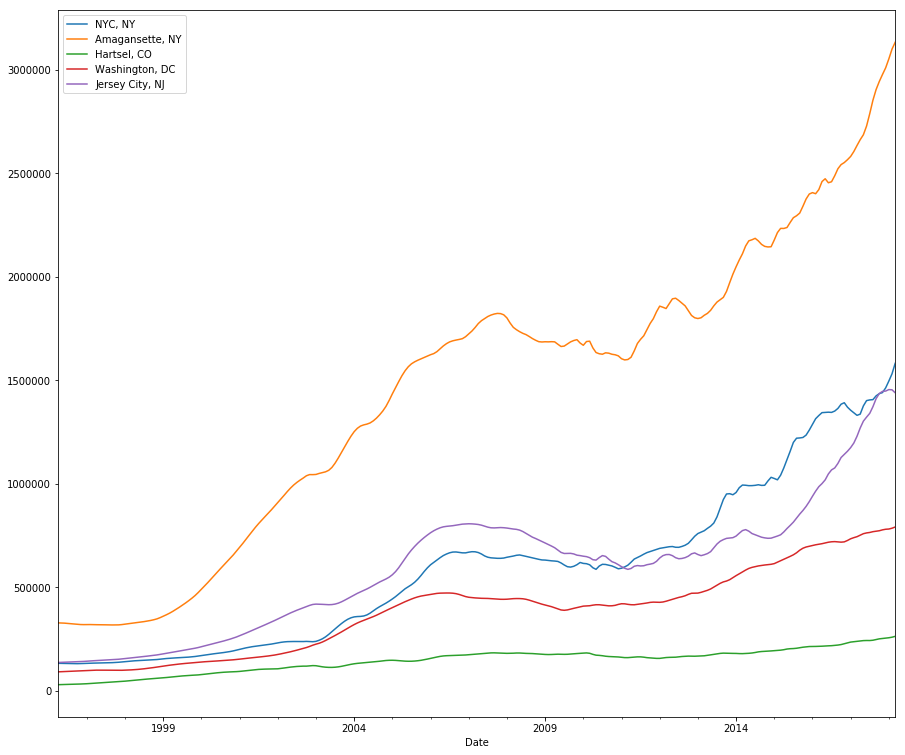

In [18]:
top_zips_series.plot(figsize=(15,13)) #Graphing the time series 
plt.legend(['NYC, NY', 'Amagansette, NY', 'Hartsel, CO', 'Washington, DC', 'Jersey City, NJ'])

There is a obvious trend in the graph above. This is expected as generally real estate appreciates over time. Furthermore, given we selected the zip codes with a high ROI, we would expect the trend lines to have a positive trend. 

Note the subtle drop in housing prices in 2007-2009 due to the financial crisis. 

# Step 4: Removing Trends and Seasonality

We need to remove the trend and possibly the seasonality in the data. This can be done with transforming data using log or square root, along with differencing and rolling means.  All of these methods will be used below to make all of our data into stationary data. 

In [19]:
#Figure out how to add in the different zips to the labels
def stationarity_check_graph(orig_df, window, zipcode): #function for stationarity through graphing a rolling mean and rolling std.
    rolling_mean= orig_df[zipcode].rolling(window=window, center= False).mean() #rolling mean
    rolling_std= orig_df[zipcode].rolling(window=window, center= False).std() #rolling std. 
    
    fig = plt.figure(figsize=(15,6))
    orig = plt.plot(orig_df[zipcode], color='blue',label='Original') #graph original data
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean') #graph rolling mean
    std = plt.plot(rolling_std, color= 'green', label= 'Rolling Std') #graph rolling std
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.title(zipcode)
    
def stationarity_check_test(orig_df, zipcode): #Dicky Fuller test to check p-value for stationarity
    dftest = adfuller(orig_df[zipcode])
    print ('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    

In [20]:
for x in top_5_zips: #Confirming the original data is not stationary
    print(x)
    stationarity_check_test(top_zips_series, x)

11211
Results of Dickey-Fuller Test:
Test Statistic                   2.202131
p-value                          0.998884
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64
11930
Results of Dickey-Fuller Test:
Test Statistic                   0.617360
p-value                          0.988036
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64
80449
Results of Dickey-Fuller Test:
Test Statistic                  -0.020433
p-value                          0.956809
#Lags Used                      16.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%

As we expected it is in fact not stationary. We will transform and try to detrend the data. 

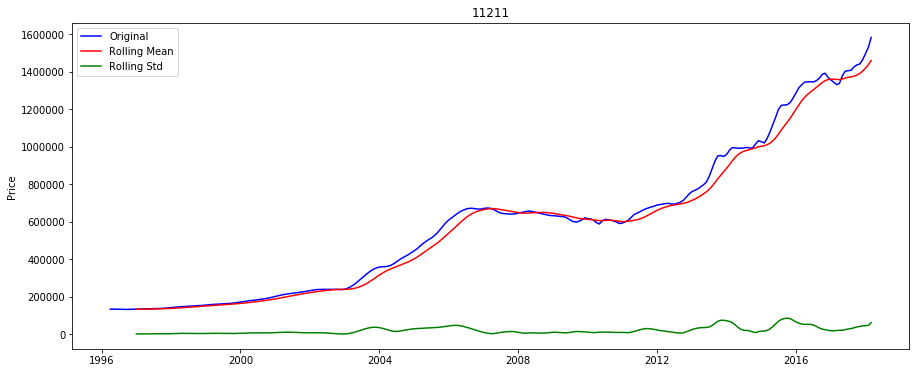

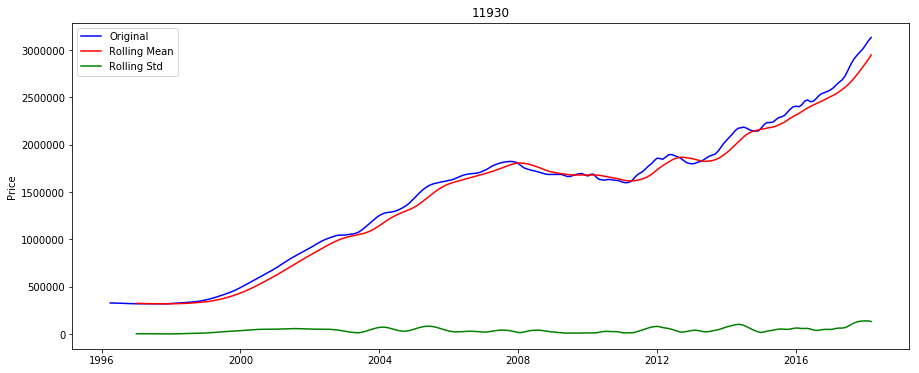

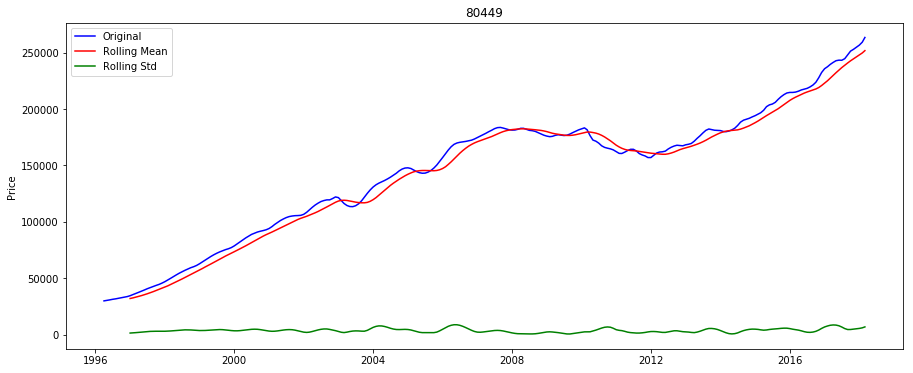

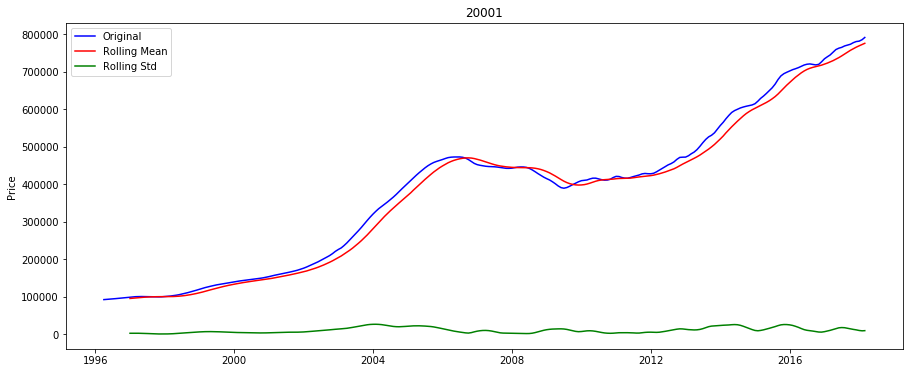

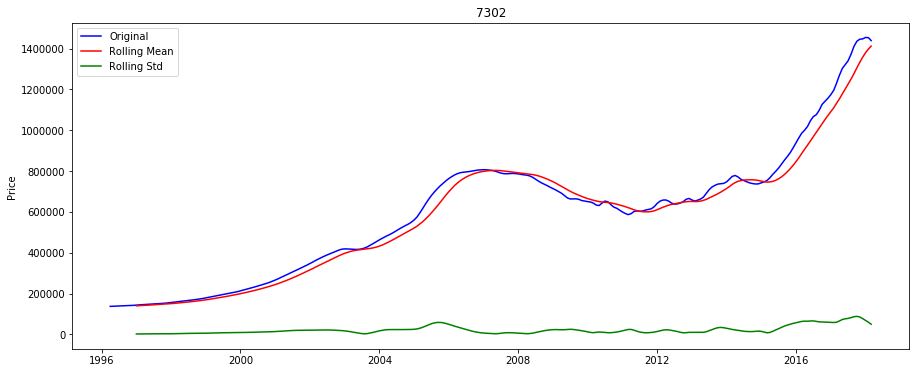

In [21]:
for x in top_5_zips: #graphs for all of the five data sets.
    stationarity_check_graph(top_zips_series, 10,x)

Above is each zip code with their corresponding rolling mean and rolling standard deviation. All of the graphs have fairly straight lines for their standard deviations which is a good sign for stationarity purposes. 

First we will try a log transform to try to create stationary data set

In [22]:
log_top_zips_series=np.log(top_zips_series) #log transform the data

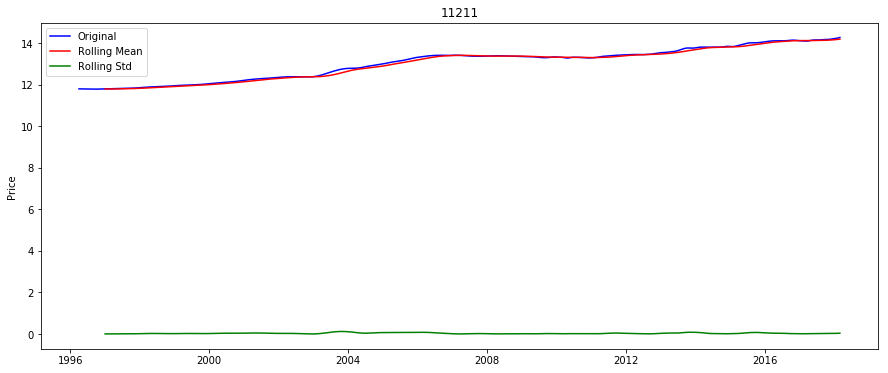

In [23]:
stationarity_check_graph(log_top_zips_series, 10, 11211) #checking just one zip code to see the effect

This did not prove to be very effective so we will try a rolling mean to get rid of our trend in our data.


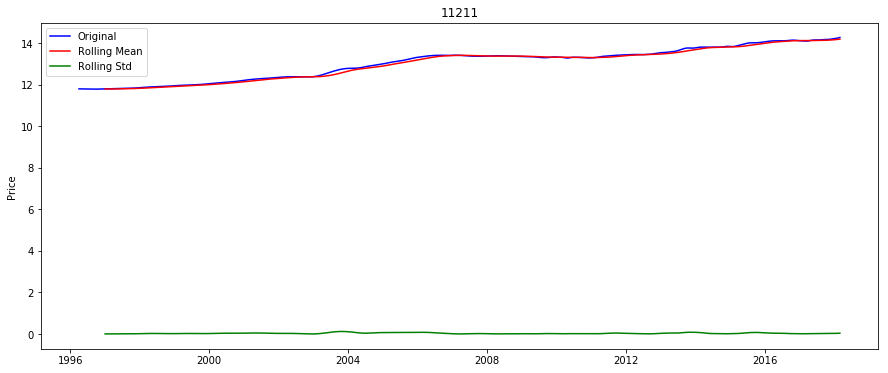

In [24]:
stationarity_check_graph(log_top_zips_series, 10, 11211) #rolling mean is graphed from logged data

As you can see these two graphs are not very different whatsoever. Clearly we need to try something else to help our data become even more stationary. 

Next we will try subtracting the rolling mean from the log transformed data to see if that benefits our data.

In [25]:
roll_mean_sub= log_top_zips_series-(log_top_zips_series.rolling(window=4 ,center=False).mean())
roll_mean_sub.dropna(inplace=True)

In [26]:
stationarity_check_test(roll_mean_sub,11211) #The p-value did go down quiet a bit, but still far from the .05 goal

Results of Dickey-Fuller Test:
Test Statistic                  -2.747436
p-value                          0.066183
#Lags Used                      15.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


We are going to use 11211 as our one test subject so to speak to look at. 

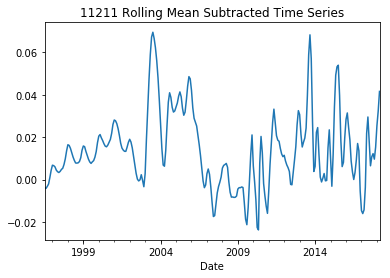

In [27]:
roll_mean_sub[11211].plot(title='11211 Rolling Mean Subtracted Time Series') #plotting just the subtracted rolling mean data for 11211

Now we are getting somewhere. Our p-value went down significantly here, so lets continue with this idea and instead of subtracting the rolling mean we will subtract the weighted rolling mean. 

In [28]:
exp_rollmean= log_top_zips_series.ewm(halflife= 2).mean() #calculating the ewm of the data
zips_minus_exp_weighted = log_top_zips_series - exp_rollmean

In [29]:
stationarity_check_test(zips_minus_exp_weighted, 11211) #Dick Fuller to see what the pvalue is

Results of Dickey-Fuller Test:
Test Statistic                  -2.263419
p-value                          0.184037
#Lags Used                      16.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


Since this increased our p-value, we are going to use the normal rolling mean instead of the exponetial weighted movign average. We are going to use differencing to see if we can get our p-value below the acceptable .05 level for us to call our data stationary. 

In [30]:
zip_codes_diff= roll_mean_sub.diff(periods=10)
zip_codes_diff.dropna(inplace=True)

Note: Using periods=10 because we are dealing with financial data and this is the recommended number of periods for such data.

In [31]:
stationarity_check_test(zip_codes_diff, 11211) #Dicky Fuller for p-value (significantly went down)

Results of Dickey-Fuller Test:
Test Statistic                  -5.257198
p-value                          0.000007
#Lags Used                      16.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


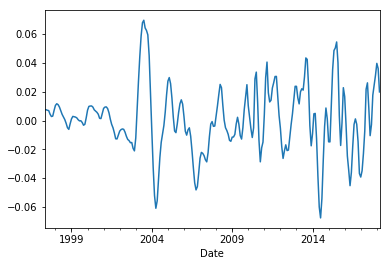

In [32]:
zip_codes_diff[11211].plot() #checking the plot of the differencing time series

Since this got us a very low p-value for 11211, we will now check to see if the rest of the data using our defined Dicky Fuller test. 

In [33]:
for x in top_5_zips:
    print(x)
    stationarity_check_test(zip_codes_diff, x)

11211
Results of Dickey-Fuller Test:
Test Statistic                  -5.257198
p-value                          0.000007
#Lags Used                      16.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64
11930
Results of Dickey-Fuller Test:
Test Statistic                  -4.127868
p-value                          0.000871
#Lags Used                      15.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64
80449
Results of Dickey-Fuller Test:
Test Statistic                -6.016696e+00
p-value                        1.527672e-07
#Lags Used                     1.600000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critica

Great news! We have all significant p-values meaning the data is now stationary! We can proceed to modeling now. First we will show what the stationary data looks like below. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d13c2b0>,
      dtype=object)

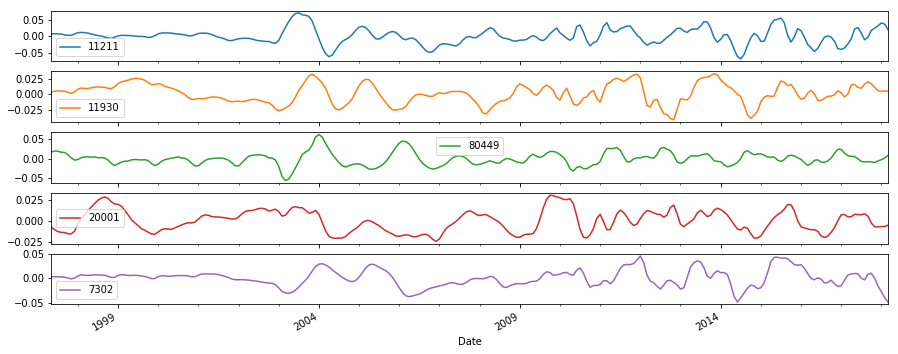

In [34]:
zip_codes_diff.plot(figsize=(15,6),subplots=True)

# Step 5: ARIMA Modeling

This is the last step in the process. We need to model our data now that it is stationary to come up with the forecasted prices of the housing markets in each zip code. From there we will then do another ROI on the real estate market in each zip code comparing 3, 5, and 10 years predictions. 

First we will plot autocorrelation graphs to look at our data

In [35]:
top_zips=[11211, 11930, 80449, 20001, 7302]

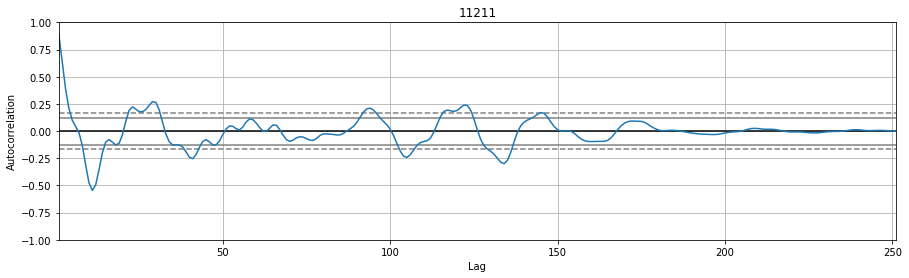

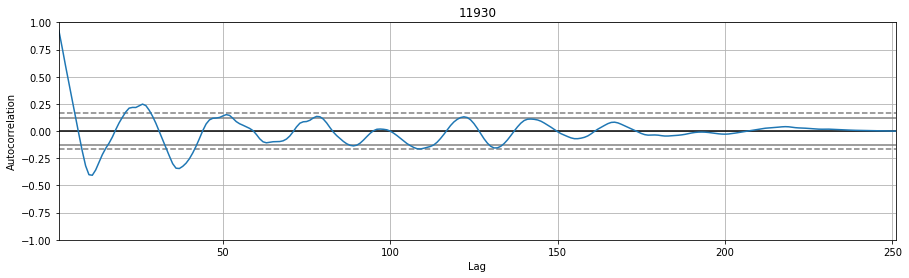

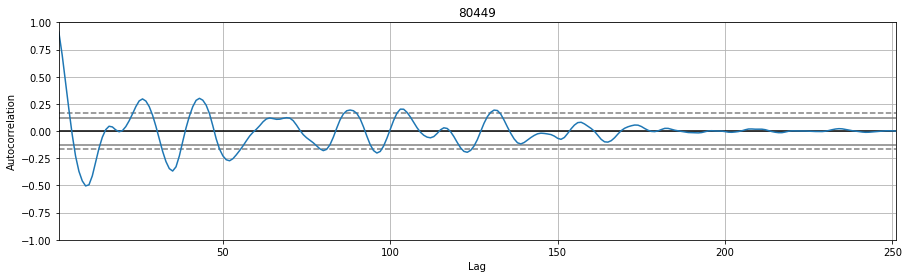

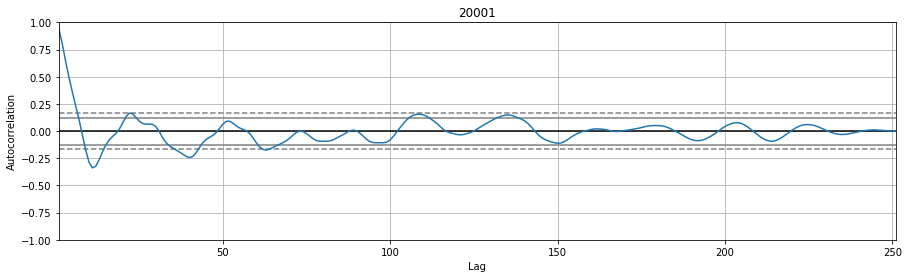

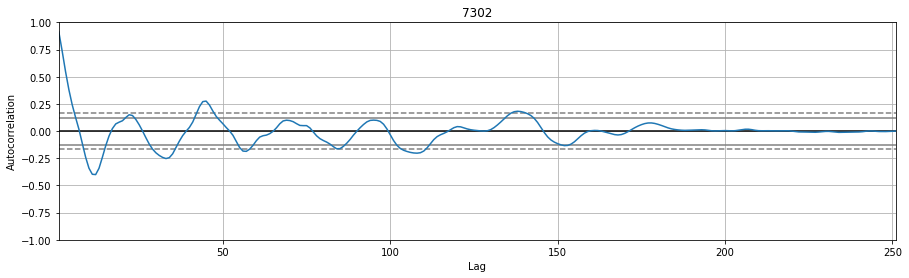

In [36]:
for x in top_zips_series:
    top_zips=[11211, 11930, 80449, 20001, 7302]
    plt.figure(figsize=(15,4))
    df=autocorrelation_plot(zip_codes_diff[x])
    plt.title(x)

Looks like from our autocorrelation we want to set the max for p and q should be around 5. 

#### Auto Build of SARIMA model

Due to seasonility we will use this model as this accounts for seasonality. The following package pmdarima (pm) is a way to automatically choose our parameters p, q, and d. Further information is below on the parameters:

1. p: order of AR term (Auto Regressive)
2. q: order of the MA term (Moving Average)
3. d: number of differencing required to make time series stationary 



From our autocorrelation it looks like we should set our max at around 2 or 3.

In [37]:
import pmdarima as pm
smodel = pm.auto_arima(zip_codes_diff[11211], start_p=1, start_q=1,
                         test='adf',
                         max_p=2, max_q=2, m=12,
                         start_P=0, seasonal=False,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 1, 1); AIC=-1738.089, BIC=-1724.003, Fit time=0.339 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-1551.085, BIC=-1544.043, Fit time=0.011 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-1670.224, BIC=-1659.660, Fit time=0.040 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-1708.132, BIC=-1697.568, Fit time=0.045 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-1775.110, BIC=-1757.503, Fit time=0.133 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-1775.736, BIC=-1761.650, Fit time=0.089 seconds
Total fit time: 0.661 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  250
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 891.868
Method:                       css-mle   S.D. of innovations              0.007
Date:                Mon, 01 Jul 2019   AIC                          -1775.736
Time:                        21:46:14   BIC                          -1761.650
Sample:                             1   HQIC                         -1770.067
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.218e-05      0.001      0.031      0.975      -0.001       0.001
ar.L1.D.y      0.9902      0.051     19.408      0.000       0.890       1.090
ar.L2.D.y     -0.5918      0.051    -11.651      0.000      -0.691      -0.492
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8367           -0.9949j            1.3000           -0.1387
AR.2            0.8367           +0.9949j            1.3000            0.1387
-----------------------------------------------------------------------------
"""

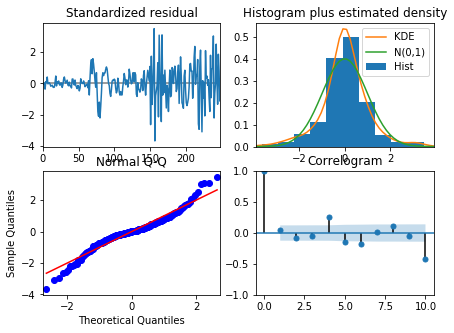

In [38]:
smodel.plot_diagnostics(figsize=(7,5))
plt.show()

So we have tried multiple parameters and have found that the below model is best and returns a accurate model.  

In [39]:
def predict(coef, history): #defining our prediction function
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat
 
def difference(dataset): #defining a differencing function
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return np.array(diff)
 
series = top_zips_series #defining all of our variables like the train and test data, specific series, and etc. 
X = top_zips_series[11211]
size = int(len(X)*.2)
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0)) #model created
    model_fit = model.fit(trend='nc', disp=False) #model fitted
    ar_coef, ma_coef = model_fit.arparams, model_fit.maparams #coefficients created from model
    resid = model_fit.resid #residual var created
    diff = zip_codes_diff[11211] #differencing data
    yhat = history[-1] + predict(ar_coef, diff) + predict(ma_coef, resid) #created the yhat or the prediction
    predictions.append(yhat) #Creating a list of all the predictions 
    obs = test[t]
    history.append(obs)
    print('>predicted=%.3f, expected=%.3f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

>predicted=183100.020, expected=185200.000
>predicted=185200.020, expected=187500.000
>predicted=187500.020, expected=190000.000
>predicted=190000.020, expected=193100.000
>predicted=193100.020, expected=196900.000
>predicted=196900.020, expected=200700.000
>predicted=200700.020, expected=204300.000
>predicted=204300.020, expected=207800.000
>predicted=207800.020, expected=210900.000
>predicted=210900.020, expected=213500.000
>predicted=213500.020, expected=215600.000
>predicted=215600.020, expected=217600.000
>predicted=217600.020, expected=219600.000
>predicted=219600.020, expected=221500.000
>predicted=221500.020, expected=223500.000
>predicted=223500.020, expected=226100.000
>predicted=226100.020, expected=229000.000
>predicted=229000.020, expected=232000.000
>predicted=232000.020, expected=234500.000
>predicted=234500.020, expected=236500.000
>predicted=236500.020, expected=237800.000
>predicted=237800.019, expected=238400.000
>predicted=238400.019, expected=238500.000
>predicted=

>predicted=1364000.017, expected=1384400.000
>predicted=1384400.017, expected=1391500.000
>predicted=1391500.017, expected=1370100.000
>predicted=1370100.017, expected=1355300.000
>predicted=1355300.017, expected=1343200.000
>predicted=1343200.017, expected=1330600.000
>predicted=1330600.017, expected=1336400.000
>predicted=1336400.017, expected=1376100.000
>predicted=1376100.017, expected=1401700.000
>predicted=1401700.016, expected=1405100.000
>predicted=1405100.016, expected=1406400.000
>predicted=1406400.016, expected=1424700.000
>predicted=1424700.016, expected=1435300.000
>predicted=1435300.016, expected=1440500.000
>predicted=1440500.016, expected=1463100.000
>predicted=1463100.016, expected=1496100.000
>predicted=1496100.016, expected=1531100.000
>predicted=1531100.017, expected=1581900.000
Test RMSE: 12961.734


In [40]:
Error_RMSE=12961/591271.2121212122 #Taking the Test RMSE and dividing by the mean price of the test data

Good sign our model has around 2 percent model error which is great. Next we need to use our model to come up with the future prices of the housing markets in each zip code. From there we can deduce our new ROI for the future. 

## Proper Model and Forecast

In [41]:
def get_results(df, preds, name):
    if 'pandas.core.frame.DataFrame' in str(type(df)):
        current_price = df.iloc[-1].value
    else:
        current_price = df[-1]
    year_later = preds[11] #Accessing the correct month/year in the function. Each count is a month so 12 is a year. 
    year_5_val = preds[59]
    year_10_val = preds[-1]
    print("Current Avg Median Home Value in {}: ${:.2f}".format(name, current_price)) #Getting current price
    print("Predicted Avg Median Home Value for {} in April 2019: ${:.2f}".format(name, year_later))
    expected_appreciation_value_1 = year_later - current_price #ROI's for each of our specified future dates
    expected_appreciation_percent_1 = expected_appreciation_value_1 / current_price
    expected_appreciation_value_5 = year_5_val - current_price
    expected_appreciation_percent_5 = expected_appreciation_value_5 / current_price
    expected_appreciation_value_10 = year_10_val - current_price
    expected_appreciation_percent_10 = expected_appreciation_value_10 / current_price
    print("Expected property value appreciation for 1 year in {} :  ${:.2f}".format(name, expected_appreciation_value_1))
    print("Expected Return on Investment after 1 year:  {:.4f}%".format(expected_appreciation_percent_1 * 100))
    print("Expected property value appreciation for 5 years in {} :  ${:.2f}".format(name, expected_appreciation_value_5))
    print("Expected Return on Investment after 5 years:  {:.4f}%".format(expected_appreciation_percent_5 * 100))
    print("Expected property value appreciation for 10 years in {} :  ${:.2f}".format(name, expected_appreciation_value_10))
    print("Expected Return on Investment after 10 years:  {:.4f}%".format(expected_appreciation_percent_10 * 100))

In [42]:
def fit_model(df, zipcode, show_graph=True):
    # Get only the values from the dataframe
    vals = df.values
    # Split the data into training and testing sets by holding out dates past a certain point. Below, we use index 261 for
    # this split
    train = vals[:50]
    test = vals[50:]
    # Use a list comprehension to create a "history" list using our training data values
    history = [i for i in train]
    # initialize an empty list for predictions
    preds = []
    # loop through a list the length of our training set
    for i in range(len(test)):
        # create an ARIMA model and pass in our history list. Also set `order=(0,1,1)` (order refers to AR and MA params--
        # see statsmodels documentation for ARIMA for more details)
        model = ARIMA(history, order=(1,1,0))
        # Fit the model we just created
        fitted_model = model.fit(disp=0)
        # Get the forecast of the next value from our fitted model, and grab the first value to use as our 'y-hat' prediction
        output = fitted_model.forecast()
        y_hat = output[0]
        # append y_hat to our list of predictions
        preds.append(y_hat)
        obs = test[i]
        # Get the actual ground truth value for this datetime and append it to the history array
        history.append(obs)
    # get the forecast for the next three years (1 month==1 timestep in our data)
    future_preds = fitted_model.forecast(steps=120)[0]
    # Visualize the ARIMA model's predictions vs the actual ground truth values for our test set
    if show_graph == True:
        print('Predicted: {} \t Expected: {}'.format(y_hat, obs))
        # Also calculate the MSE
        mse = mean_squared_error(test, preds)
        print("MSE for Test Set: {}".format(mse))
        plt.plot(test, color= 'b')
        plt.plot(preds, color='r')
        plt.ylabel('Median Home Value ($)')
        plt.title('Predicted vs Expected Median Home Sale Values'.format(zipcode))
        plt.legend(['Actual', 'Predicted'])
        plt.show()
        plt.figure()
        plt.plot(future_preds)
        plt.ylabel('Median Home Value ($)')
        plt.title('Predicted Home Value, {}, Next 10 Years (120 Months)'.format(zipcode))
        plt.show()
        get_results(df, future_preds, zipcode)

### Zip Code 11211 NY, NY (King County)

Predicted: [1559661.58818859] 	 Expected: 1581900.0
MSE for Test Set: 52270253.86222441


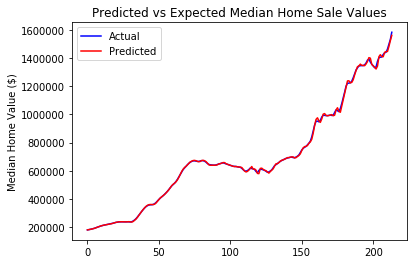

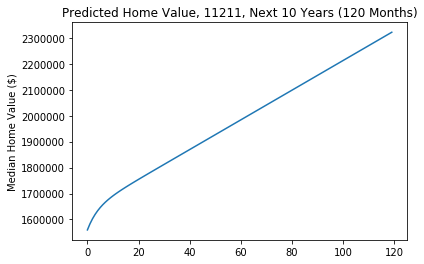

Current Avg Median Home Value in 11211: $1581900.00
Predicted Avg Median Home Value for 11211 in April 2019: $1698356.96
Expected property value appreciation for 1 year in 11211 :  $116456.96
Expected Return on Investment after 1 year:  7.3618%
Expected property value appreciation for 5 years in 11211 :  $396456.71
Expected Return on Investment after 5 years:  25.0621%
Expected property value appreciation for 10 years in 11211 :  $739864.74
Expected Return on Investment after 10 years:  46.7706%


In [43]:
fit_model(top_zips_series[11211],11211) # calling function to plot and see our future prices fro 11211 zip code

Now we will repeat for the remaining zip codes. 

### 11930 NY, NY (Suffolk County)



Predicted: [3140354.49322663] 	 Expected: 3132200.0
MSE for Test Set: 86056755.91497074


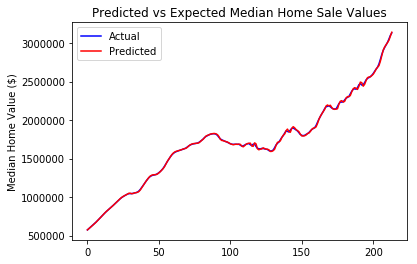

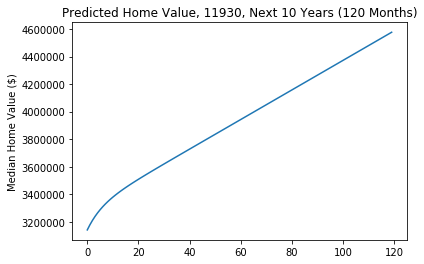

Current Avg Median Home Value in 11930: $3132200.00
Predicted Avg Median Home Value for 11930 in April 2019: $3393790.98
Expected property value appreciation for 1 year in 11930 :  $261590.98
Expected Return on Investment after 1 year:  8.3517%
Expected property value appreciation for 5 years in 11930 :  $799920.36
Expected Return on Investment after 5 years:  25.5386%
Expected property value appreciation for 10 years in 11930 :  $1444904.73
Expected Return on Investment after 10 years:  46.1307%


In [44]:
fit_model(top_zips_series[11930],11930)

### 80449 Hartsel, CO 



Predicted: [261544.44899808] 	 Expected: 263400.0
MSE for Test Set: 597706.5465443875


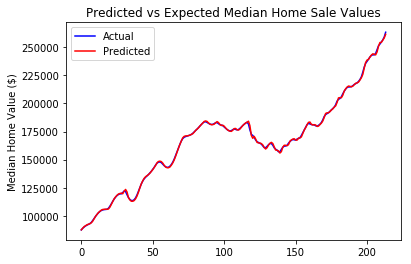

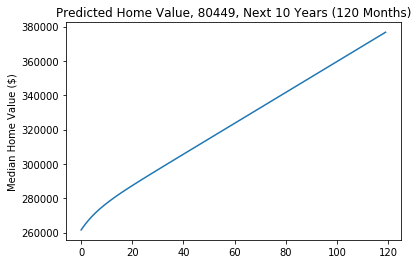

Current Avg Median Home Value in 80449: $263400.00
Predicted Avg Median Home Value for 80449 in April 2019: $278244.86
Expected property value appreciation for 1 year in 80449 :  $14844.86
Expected Return on Investment after 1 year:  5.6359%
Expected property value appreciation for 5 years in 80449 :  $59355.27
Expected Return on Investment after 5 years:  22.5343%
Expected property value appreciation for 10 years in 80449 :  $113289.05
Expected Return on Investment after 10 years:  43.0103%


In [45]:
fit_model(top_zips_series[80449],80449)

### 20001 Washington, DC


Predicted: [789316.08661759] 	 Expected: 791400.0
MSE for Test Set: 1822471.4159841738


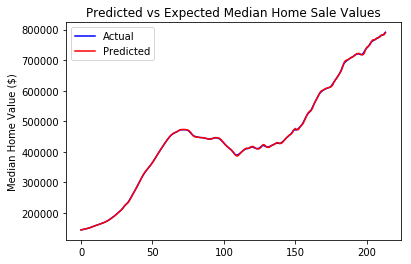

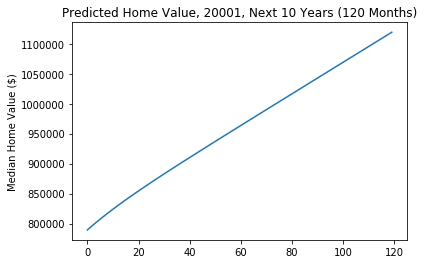

Current Avg Median Home Value in 20001: $791400.00
Predicted Avg Median Home Value for 20001 in April 2019: $827109.24
Expected property value appreciation for 1 year in 20001 :  $35709.24
Expected Return on Investment after 1 year:  4.5122%
Expected property value appreciation for 5 years in 20001 :  $169629.82
Expected Return on Investment after 5 years:  21.4341%
Expected property value appreciation for 10 years in 20001 :  $327859.86
Expected Return on Investment after 10 years:  41.4278%


In [46]:
fit_model(top_zips_series[20001],20001)

### 7302 Jersey City, NJ

Predicted: [1453501.43135369] 	 Expected: 1439500.0
MSE for Test Set: 20766918.752560563


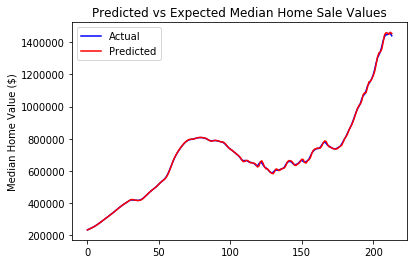

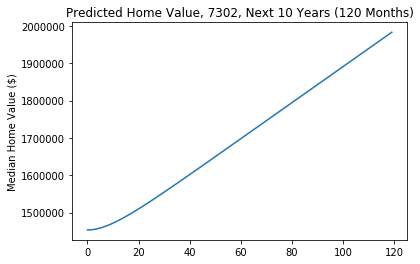

Current Avg Median Home Value in 7302: $1439500.00
Predicted Avg Median Home Value for 7302 in April 2019: $1474898.14
Expected property value appreciation for 1 year in 7302 :  $35398.14
Expected Return on Investment after 1 year:  2.4591%
Expected property value appreciation for 5 years in 7302 :  $253565.18
Expected Return on Investment after 5 years:  17.6148%
Expected property value appreciation for 10 years in 7302 :  $543255.36
Expected Return on Investment after 10 years:  37.7392%


In [47]:
fit_model(top_zips_series[7302],7302)

# Step 6: Interpreting Results

Initial Reaction: 

1. All of the zip codes selected have around a 40 percent ROI after 10 years which is very good.  
2. Weirdly all of the zip codes have a sort of down turn or bad couple months between 100 (8.3 years) and 150 (12.5 years) which could mean maybe there is going to be a recession. 
3. 11211 had the highest return coming in around 50 percent ROI after 10 years. This is expected the Williamsburg housing market is jumping currently and will not be slowing down anytime soon. 
4. The most expensive zip code is the Suffolk, NY County due to it being in a prime beach/general location for New Yorkers.
5. The least expensive zip code is Hartsel, Colorado and saw the second highest ROI. 


### Recommendations 

I would recommend investing in all of the selected zip codes. Further analysis could be done to bring in factors like crime rate, education/school ratings, real estate taxes, and population growth over the 20 year time period. I believe the already very accurate model would become even more precise with the added features. There will of course be a recession or downward turn in the stock market over the next 10 years as we are due in the cycle. I would advise to invest in all zips for five years and see where the market is. From there re-balance the portfolio for the next 5 years as this is a normal financial protocol. 